In [35]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from torch.nn.functional import cross_entropy

from utilities import *

print("PyTorch Version:", torch.__version__)
print("Torchvision Version:", torchvision.__version__)
print("GPU is available?", torch.cuda.is_available())

PyTorch Version: 1.11.0+cu113
Torchvision Version: 0.12.0+cu113
GPU is available? True


In [36]:
dtype = torch.float
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Imported datasets
For the testing and comparison of our algorithms we will use the following datasets:

1. MNIST
2. FashionMNIST
3. CIFAR10

In [37]:
ts = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

# change the flag to choose the dataset to work with
dataset_flag = 1

if dataset_flag ==0:
  trainset = datasets.MNIST('../data', train=True, download=True, transform=ts)
  testset = datasets.MNIST(root='../data', train=False, download=True, transform=ts)
elif dataset_flag ==1:
  trainset = datasets.FashionMNIST('../data', train=True, download=True, transform=ts)
  testset = datasets.FashionMNIST(root='../data', train=False, download=True, transform=ts)
else:
  trainset = datasets.CIFAR10('../data', train=True, download=True, transform=ts)
  testset = datasets.CIFAR10(root='../data', train=False, download=True, transform=ts)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [38]:
"""
from sklearn import datasets
from sklearn.model_selection import train_test_split

boston = datasets.load_boston()
X = boston.data
y = boston.target
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

x_train = torch.from_numpy(x_train).to(device = device)
x_test = torch.from_numpy(x_test).to(device = device)
y_train = torch.from_numpy(y_train).to(device = device)
y_test = torch.from_numpy(y_test).to(device = device)

x_train = x_train.T.float()
x_test = x_test.T.float()

N = x_train.shape[1]
N_test = x_test.shape[1]
"""

'\nfrom sklearn import datasets\nfrom sklearn.model_selection import train_test_split\n\nboston = datasets.load_boston()\nX = boston.data\ny = boston.target\nx_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)\n\nx_train = torch.from_numpy(x_train).to(device = device)\nx_test = torch.from_numpy(x_test).to(device = device)\ny_train = torch.from_numpy(y_train).to(device = device)\ny_test = torch.from_numpy(y_test).to(device = device)\n\nx_train = x_train.T.float()\nx_test = x_test.T.float()\n\nN = x_train.shape[1]\nN_test = x_test.shape[1]\n'

# Dataset preprocessing

In [39]:
x_train, y_train, x_test, y_test, y_train_one_hot, y_test_one_hot, _, _= load_dataset(trainset, testset, 10)

# We move to GPU
x_train = x_train.to(device = device)
x_test = x_test.to(device = device)
y_train = y_train.to(device = device)
y_test = y_test.to(device = device)
y_train_one_hot = y_train_one_hot.to(device = device)
y_test_one_hot = y_test_one_hot.to(device = device)

# Architecture initialization

For the MultiLayerPerceptron we have the parameters **input_size** , **hidden_size**,**output_size** corresponding to the size of the input layer, the hidden layer and the output layer, respectively.

The MLP only has 3 layers like https://github.com/timlautk/BCD-for-DNNs-PyTorch/blob/master/bcd_dnn_mlp_mnist.ipynb as a starting point.

Also we use ReLU currently for the same reason.

In [40]:
input_size = x_train.shape[0]
hidden_size = 1500
output_size = 10

cross_entropy = nn.CrossEntropyLoss()

# Training

Note: Fix it so that it moves everything to device in the following function and that it does the label sample split here

In [41]:
def update_v_js(U1, U2, W, b, rho, gamma):
    """
    The function updates the V_js parameters during the training phase
    
    :param U1: The U parameter on the same level of V that we are updating
    :param U2: The U parameter which is in the next level of the V that we are updating
    :param W: The W parameter which is in the next level of the V that we are updating
    :param b: The b parameter which is in the next level of the V that we are updating
    :param rho: The constant rho parameter which is in the next level of the V that we are updating
    :param gamma: The constant gamma parameter which is in the next level of the V that we are updating
    :return: The updated V
    """
    _, d = W.size()
    I = torch.eye(d, device=device)
    U1 = nn.ReLU()(U1)
    _, col_U2 = U2.size()
    Vstar = torch.mm(torch.inverse(rho * (torch.mm(torch.t(W), W)) + gamma * I),
                     rho * torch.mm(torch.t(W), U2 - b.repeat(1, col_U2)) + gamma * U1)
    return Vstar

In [42]:
def update_wb_js(U, V, W, b, alpha, rho):
    """
    The function updates the W and b parameters during the training phase
    
    :param U: The U in the current level of W and b
    :param V: The V in the previous level with respect to the W that we are updating
    :param W: The current W that we have to update
    :param b: The current b that we have to update
    :param alpha: The alpha constant of the updates
    :param rho: The rho constant of the updates
    :return:
    """
    d, N = V.size()
    I = torch.eye(d, device=device)
    _, col_U = U.size()
    Wstar = torch.mm(alpha * W + rho * torch.mm(U - b.repeat(1, col_U), torch.t(V)),
                     torch.inverse(alpha * I + rho * (torch.mm(V, torch.t(V)))))
    bstar = (alpha * b + rho * torch.sum(U - torch.mm(W, V), dim=1).reshape(b.size())) / (rho * N + alpha)
    return Wstar, bstar

In [43]:
def relu_prox(a, b, gamma, d, N):
    """
    The function compute the solution to the relu proximal update problem
    
    :param a: the a in the closed formula of the linearized update
    :param b: the b in the closed formula of the linearized update
    :param gamma: The constant used in the update
    :param d: the dimension of the current layer
    :param N: The number of samples
    :return: The obtained solution of the prox update
    """
    val = torch.empty(d, N, device=device)
    x = (a + gamma * b) / (1 + gamma)
    y = torch.min(b, torch.zeros(d, N, device=device))
    val = torch.where(a + gamma * b < 0, y, torch.zeros(d, N, device=device))
    val = torch.where(
        ((a + gamma * b >= 0) & (b >= 0)) | ((a * (gamma - np.sqrt(gamma * (gamma + 1))) <= gamma * b) & (b < 0)), x,
        val)
    val = torch.where((-a <= gamma * b) & (gamma * b <= a * (gamma - np.sqrt(gamma * (gamma + 1)))), b, val)
    return val


In [44]:
def make_pred(Ws,bs,input,N):
  """
  The function is used to make the predictions based on the best found parameters
  :param Ws: The weight matrices
  :param bs: the bias vectors
  :return pred, prob
  """
  a1_train = input
  for i in range(0,len(Ws)-1):
    a1_train = nn.ReLU()(torch.addmm(bs[i].repeat(1, N), Ws[i], a1_train))
  pred = torch.argmax(torch.addmm(bs[len(Ws)-1].repeat(1, N), Ws[len(Ws)-1], a1_train), dim=0)
  output_last = torch.addmm(bs[len(Ws)-1].repeat(1, N), Ws[len(Ws)-1], a1_train)
  prob = torch.exp(output_last)/torch.sum(torch.exp(output_last),dim=0)
  return pred, prob

In [45]:
#The function requires at least 1 hidden layer otherwise it need some rewriting

def execute_training(layers, input_size, hidden_size, output_size, train_set, val_set, 
                     train_labels, val_labels, y_train_one_hot, y_test_one_hot,
                     use_gradient, niter = 100, gamma = 1, alpha = 5, verbose = True):
  """
  The function takes the following arguements and produces a list of weights and biases with which 
  you can use the make_pred function to get a list of predictions
  :param layers: The total number of layers of the network
  :param input_size: The total size of the input layer
  :param hidden_size: The size of the hidden layer
  :param output_size: The size of the output layer (usefull for multiclass classification)
  :param train_set: The training set
  :param val_set: The validation set
  :param train_labels: The training labels
  :param val labels: The validation labels
  :param y_train_one_hot: The one hot encoding of the training labels
  :param y_test_one_hot: The one hot encoding of the test labels
  :param use_gradient: True if the first update of V is carried out without linearization but using the gradient
  :param niter: The default number of epochs to train the network
  :param gamma: The gamma parameter of the algorithm
  :param alpha: The alpha parameter of the algorithm
  :param verbose: If verbose = True it displays the evolution of the metrics during training, otherwise it does not
  :return loss1, loss_class, opt_accuracy, accuracy_test, early_Ws, early_bs:
  Returns the loss, the cross-entropy losses, the best accuracy, the accuracies
  of the validation set, the best found weights and biases
  """

  # we set the seed for reproducibility
  torch.manual_seed(42)

  N = len(train_labels)
  N_test = len(val_labels)

  # weight initialization (we replicate pytorch weight initialization)

  std = math.sqrt(1/input_size)
  W = torch.FloatTensor(hidden_size, input_size).uniform_(-std, std)
  b = torch.FloatTensor(hidden_size, 1).uniform_(-std, std)

  b = b.to(device = device)
  W = W.to(device = device)

  U = torch.addmm(b.repeat(1, N), W, x_train) # equivalent to W1@x_train+b1.repeat(1,N)
  V = nn.ReLU()(U)

  Ws = [W]
  bs = [b]
  Us = [U]
  Vs = [V]

  for i in range(1,layers-1):
    std = math.sqrt(1/hidden_size)
    W = torch.FloatTensor(hidden_size, hidden_size).uniform_(-std, std)
    b = torch.FloatTensor(hidden_size, 1).uniform_(-std, std)
    b = b.to(device = device)
    W = W.to(device = device)
    U = torch.addmm(b.repeat(1, N), W, Vs[-1])
    V = nn.ReLU()(U)
    Ws.append(W)
    bs.append(b)
    Us.append(U)
    Vs.append(V)
  
  std = math.sqrt(1/hidden_size)
  W = torch.FloatTensor(output_size, hidden_size).uniform_(-std, std)
  b = torch.FloatTensor(output_size, 1).uniform_(-std, std)

  # we move them to GPU
  b = b.to(device = device)
  W = W.to(device = device)
  U = torch.addmm(b.repeat(1, N), W, Vs[-1])
  V = U
  Ws.append(W)
  bs.append(b)
  Us.append(U)
  Vs.append(V)
  
  # constant initialization

  gamma1 = gamma2 = gamma3 = gamma4 = gamma

  rho = gamma
  rho1 = rho2 = rho3 = rho4 = rho

  alpha1 = alpha2 = alpha3 = alpha4 = alpha5 = alpha6 = alpha7 \
  = alpha8 = alpha9 = alpha10 = alpha

  # vector of performance initialization

  loss1 = np.empty(niter)
  loss2 = np.empty(niter)
  loss_class = np.empty(niter)
  accuracy_train = np.empty(niter)
  accuracy_test = np.empty(niter)
  time1 = np.empty(niter)

  opt_accuracy = 0
  early_Ws = Ws
  early_bs = bs
  time_best = 0
  num_epochs_best =0

  print('Train on', N, 'samples, validate on', N_test, 'samples')
  for k in range(niter):

    start = time.time()

    # update V3
    if use_gradient == True:
      if (k == 1):
        Vs[-1] = (y_train_one_hot + gamma3*Us[-1] + alpha1*Vs[-1])/(1+ gamma3 + alpha1)
      else:
        for i in range(250):
          Vs[-1] = Vs[-1] - (torch.exp(Vs[-1])/torch.sum(torch.exp(Vs[-1]),dim=0)-y_train_one_hot) * 0.01/(i+1)
    else:
      Vs[-1] = (y_train_one_hot + gamma3*Us[-1] + alpha1*Vs[-1])/(1+ gamma3 + alpha1)

    # update U3 
    Us[-1] = (gamma3*Vs[-1] + rho3*(torch.mm(Ws[-1],Vs[-2]) + bs[-1].repeat(1,N)))/(gamma3 + rho3)

    # update W3 and b3
    W, b = update_wb_js(Us[-1],Vs[-2],Ws[-1],bs[-1],alpha1, rho3)
    Ws[-1] = W
    bs[-1] = b

    for i in range(len(Vs)-2,0,-1):
      Vs[i] = update_v_js(Us[i],Us[i+1],Ws[i+1],bs[i+1],rho3,gamma2)
      Us[i] = relu_prox(Vs[i],(rho2*torch.addmm(bs[i].repeat(1,N), Ws[i], Vs[i-1]) +
                               alpha2*Us[i])/(rho2 + alpha2),(rho2 + alpha2)/gamma2, hidden_size, N)
      W,b = update_wb_js(Us[i],Vs[i-1],Ws[i],bs[i],alpha3,rho2)
      Ws[i] = W
      bs[i]= b
    
    # update V1
    Vs[0] = update_v_js(Us[0],Us[1],Ws[1],bs[1],rho2,gamma1)
        
    # update U1
    Us[0] = relu_prox(Vs[0],(rho1*torch.addmm(bs[0].repeat(1,N), Ws[0], x_train) +
                             alpha7*Us[0])/(rho1 + alpha7),(rho1 + alpha7)/gamma1, hidden_size, N)
    
    # update W1 and b1
    W, b = update_wb_js(Us[0],x_train,Ws[0],bs[0],alpha8,rho1)
    Ws[0] = W
    bs[0] = b


    pred,_ = make_pred(Ws,bs,x_train,N)
    pred_test, prob_test = make_pred(Ws,bs,x_test,N_test) 

    
    loss_class[k] = torch.sum(- y_test_one_hot * torch.log(prob_test))

    loss1[k] = gamma/2*torch.pow(torch.dist(Vs[-1],y_train_one_hot,2),2).cpu().numpy()
    loss2[k] = loss1[k] + gamma/2 * torch.pow(torch.dist(torch.addmm(bs[0].repeat(1,N), Ws[0], x_train),Us[0],2),2).cpu().numpy()

    for i in range(1,layers):
      loss2[k] = loss2[k] + gamma/2 * torch.pow(torch.dist(torch.addmm(bs[i].repeat(1,N), Ws[i], Vs[i-1]),Us[i],2),2).cpu().numpy()

        
    # compute training accuracy
    correct_train = pred == train_labels
    accuracy_train[k] = np.mean(correct_train.cpu().numpy())
        
    # compute validation accuracy
    correct_test = pred_test == val_labels
    accuracy_test[k] = np.mean(correct_test.cpu().numpy())
        
    # compute training time
    stop = time.time()
    duration = stop - start
    time1[k] = duration
        
    # print results
    if(verbose == True):
      print('Epoch', k + 1, '/', niter, '\n', 
            '-', 'time:', time1[k], '-', 'sq_loss:', loss1[k], '-', 'tot_loss:',
            loss2[k], '-', 'loss_class:', loss_class[k], '-', 'acc:',
            accuracy_train[k], '-', 'val_acc:', accuracy_test[k])
    
    if(accuracy_test[k]>opt_accuracy):
      early_Ws = Ws
      early_bs = bs
      opt_accuracy = accuracy_test[k]
      time_best = np.sum(time1[0:k])
      num_epochs_best=k
    
  print('\n The total time spent is:', np.sum(time1), 's')
  print('\n The best accuracy reached is', opt_accuracy)
  print('\n The time needed to reach the best accuracy is', time_best, 's')
  print('\n The best accuracy has been reached after', num_epochs_best, 'iterations')

  return loss1, loss_class, opt_accuracy, accuracy_test, early_Ws, early_bs

In [46]:
def hyperparams_tuning(layers, input_size, hidden_size, output_size, train_set, val_set, 
                     train_labels, val_labels, y_train_one_hot, y_test_one_hot,
                     use_gradient, niter = 100, gammas = [1], alphas= [5]):
  """
  The function performs grid-search on the hyperparameters alpha, gamma of block
  coordinate descent.
  :param layers: The total number of layers of the network
  :param input_size: The total size of the input layer
  :param hidden_size: The size of the hidden layer
  :param output_size: The size of the output layer (usefull for multiclass classification)
  :param train_set: The training set
  :param val_set: The validation set
  :param train_labels: The training labels
  :param val labels: The validation labels
  :param y_train_one_hot: The one hot encoding of the training labels
  :param y_test_one_hot: The one hot encoding of the test labels
  :param use_gradient: True if the first update of V is carried out without linearization but using the gradient
  :param niter: The default number of epochs to train the network
  :param gammas: A list of gammas to try
  :param alphas: A list of alphas to try
  :returns best_gamma, best_alpha: The two best parameters found after grid-search
  """
  accuracies = np.zeros((len(gammas), len(alphas)))
  for i, gamma in enumerate(gammas):
    for j, alpha in enumerate(alphas):
      print('\n ######################################### \n \
      Testing gamma= {}, alpha={}'.format(gamma,alpha))
      loss, loss_class , opt_accuracy, accuracy_test, Ws, bs = execute_training(layers,
      input_size, hidden_size, output_size, x_train, x_test, y_train, y_test,
      y_train_one_hot, y_test_one_hot, use_gradient , niter, gamma = gamma,
      alpha = alpha, verbose = False)
      accuracies[i,j] = opt_accuracy
  max_acc = np.amax(accuracies)
  best_indices = np.where(accuracies == max_acc)
  return gammas[best_indices[0][0]], alphas[best_indices[1][0]], max_acc

alphas = [2, 5, 7]
gammas = [0.2, 1, 1.8]
best_gamma, best_alpha, max_acc = hyperparams_tuning (3, input_size, hidden_size,
                    output_size, x_train, x_test, y_train, y_test, y_train_one_hot,
                    y_test_one_hot, True , niter = 100, gammas = gammas, alphas = alphas)
print('\n The best found parameters are alpha = {}, gamma={}'.format(best_alpha, best_gamma))


 ######################################### 
       Testing gamma= 0.2, alpha=2
Train on 60000 samples, validate on 10000 samples

 The total time spent is: 131.78913831710815 s

 The best accuracy reached is 0.8643

 The time needed to reach the best accuracy is 52.96940636634827 s

 The best accuracy has been reached after 41 iterations

 ######################################### 
       Testing gamma= 0.2, alpha=5
Train on 60000 samples, validate on 10000 samples

 The total time spent is: 137.30834197998047 s

 The best accuracy reached is 0.8631

 The time needed to reach the best accuracy is 116.55969786643982 s

 The best accuracy has been reached after 85 iterations

 ######################################### 
       Testing gamma= 0.2, alpha=7
Train on 60000 samples, validate on 10000 samples

 The total time spent is: 137.9039101600647 s

 The best accuracy reached is 0.8633

 The time needed to reach the best accuracy is 117.1766710281372 s

 The best accuracy has been reach

In [47]:
## We retrain the model with the best found hyperparameters

loss, loss_class , opt_accuracy, accuracy_test, Ws, bs = execute_training(3,
      input_size, hidden_size, output_size, x_train, x_test, y_train, y_test,
      y_train_one_hot, y_test_one_hot, True , niter = 100, gamma = best_gamma,
      alpha = best_alpha)

Train on 60000 samples, validate on 10000 samples
Epoch 1 / 100 
 - time: 1.3568601608276367 - sq_loss: 50155.832812500004 - tot_loss: 50164.209641642876 - loss_class: 22945.57421875 - acc: 0.14336666666666667 - val_acc: 0.1412
Epoch 2 / 100 
 - time: 1.3387031555175781 - sq_loss: 32277.90234375 - tot_loss: 32332.822759974002 - loss_class: 22252.388671875 - acc: 0.7104166666666667 - val_acc: 0.6975
Epoch 3 / 100 
 - time: 1.4047269821166992 - sq_loss: 28043.5166015625 - tot_loss: 28055.42172605842 - loss_class: 21712.703125 - acc: 0.8402166666666666 - val_acc: 0.8232
Epoch 4 / 100 
 - time: 1.3807039260864258 - sq_loss: 24178.376953125 - tot_loss: 24185.734737610816 - loss_class: 21255.9296875 - acc: 0.8633166666666666 - val_acc: 0.8455
Epoch 5 / 100 
 - time: 1.3768410682678223 - sq_loss: 20675.6876953125 - tot_loss: 20683.81746364832 - loss_class: 20845.22265625 - acc: 0.87105 - val_acc: 0.8527
Epoch 6 / 100 
 - time: 1.3847732543945312 - sq_loss: 17528.312109375 - tot_loss: 17537.19

In [48]:
pickle_results("Coordinate-F-MNIST-3-1500-class",loss, loss_class , opt_accuracy,
               accuracy_test, Ws, bs, best_alpha, best_gamma)

# Analyis of the results

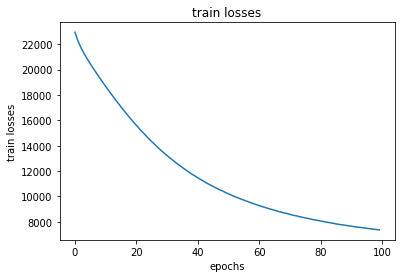

In [49]:
## We plot the train losses

plot_train_losses(loss_class.shape[0], loss_class, 'Coordinate_descent_F-MNIST-3-1500-class')

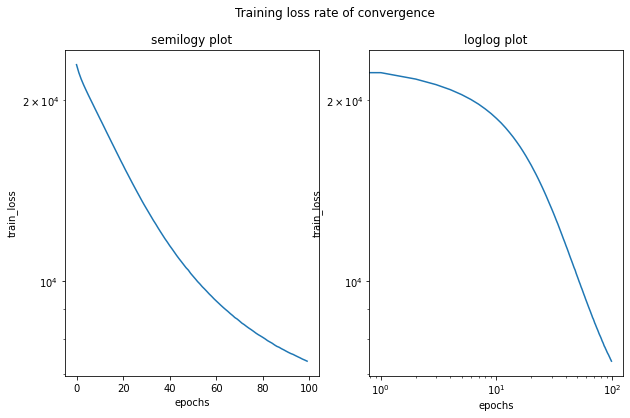

In [50]:
plot_convergence_rate_losses(loss_class.shape[0], loss_class, 'Coordinate_descent_F-MNIST-3-1500-class_rate')

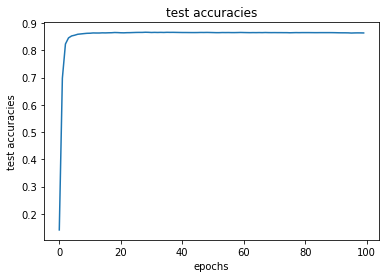

In [51]:
## We plot the test accuracy

plot_test_accuracy(accuracy_test.shape[0], accuracy_test, 'Coordinate_descent_F-MNIST-3-1500-class')
